# Analysis - Experiment 5: IT Split Range

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pylab as plt
import scipy.stats as ss

def swap_ioi_bpm(t):
    """
    Converts an interonset interval (IOI) in milliseconds to tempo in beats per minute, or
    BPM to the corresponding IOI. Conveniently, the equation is the same to convert in either
    direction - just divide 60000 ms by your value. Sometimes the universe is benign. :)
    :param t: Either an interonset interval in milliseconds or a BPM value. Can also be an array
        of these values.
    :return: If t was an interonset interval, result will be the corresponding BPM.
        If t was a tempo in BPM, result will be the corresponding interonset interval.
    """
    return 60000 / t

# Set file paths
DATAFILE = '../data/response_data.csv'
SURVEYFILE = '../data/survey_responses.csv'
EXCFILE = '../data/excluded.txt'
FIGURE_PATH = './figures/'
IOI_LEVELS = np.array([1000, 918, 843, 774, 710, 652, 599, 550, 504, 463, 425, 390, 358, 329, 302])
IOI_BINS = [(IOI_LEVELS[3*i], IOI_LEVELS[1+3*i], IOI_LEVELS[2+3*i]) for i in range(5)]
TEMPO_LEVELS = swap_ioi_bpm(IOI_LEVELS)
TEMPO_BINS = [(TEMPO_LEVELS[3*i], TEMPO_LEVELS[1+3*i], TEMPO_LEVELS[2+3*i]) for i in range(5)]
PITCH_LEVELS = [2, 3, 4, 5, 6, 7]
LOUDNESS_LEVELS = [0, 1, 2]
METRONOME_IOI = 550
METRONOME_TEMPO = swap_ioi_bpm(550)

# Define functions to convert between tempos and ratings
def bpm_to_rating(bpm, referent=METRONOME_TEMPO, intercept=50, slope=50):
    """
    Calculates location of any tempo in BPM on the scale used in the study. Appears
    in the manuscript as Equation 1.

    The default intercept and slope are the ground truth values, and assume 1) that a
    score of 50 corresponds to a tempo equal to the metronome and 2) every doubling of
    the tempo increases the score by 50. Subject-specific slopes and intercepts can be
    passed as arguments instead to obtain r_hat (see Equation 3).
    """
    return intercept + slope * np.log2(bpm / referent)

def rating_to_bpm(r, referent=METRONOME_TEMPO, intercept=50, slope=50):
    """
    Converts any relative tempo rating to its corresponding tempo in BPM.
    Appears in the manuscript as Equation 2.

    The default intercept and slope used in the equation are the ground truth values,
    but subject-specific slopes and intercepts can be passed as arguments instead to
    obtain t_hat (see Equation 4).
    """
    return referent * 2 ** ((r - intercept) / slope)

# Adjust matplotlib settings
plt.rc('figure', titlesize=32)  # fontsize of the figure title
plt.rc('axes', labelsize=28)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=23)    # fontsize of the tick labels
plt.rc('ytick', labelsize=23)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False

In [2]:
# Load data
data = pd.read_csv(DATAFILE)

# Remove excluded participants
excluded = np.loadtxt(EXCFILE, dtype=int)
data = data[~np.isin(data.subject, excluded)]

# Exclude outlier trials
data = data[data.cooks <= 4 / 180]

# Raw Tempo Ratings

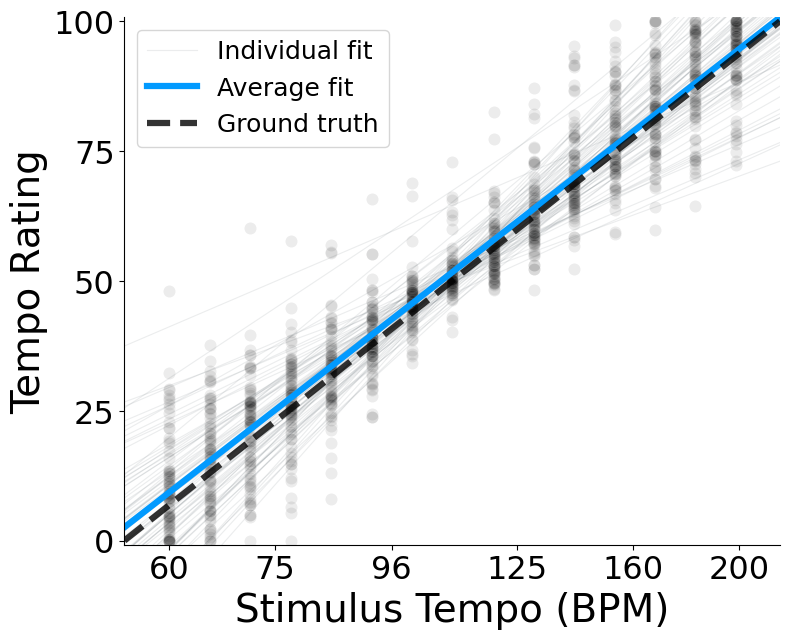

In [3]:
# Get subject averages
subj_avg = data.groupby(['subject', 'tempo']).response.mean().reset_index()
subj_slopes = data.groupby('subject').slope.mean().reset_index()
subj_intercepts = data.groupby('subject').intercept.mean().reset_index()

plt.figure()

# Scatterplot
ax = sns.scatterplot(x=np.log2(subj_avg.tempo), y='response', data=subj_avg, alpha=.075, color='k', s=75, zorder=1)

# Individual subject fits
for i in range(len(subj_slopes)):
    slope = subj_slopes.iloc[i, 1]
    intercept = subj_intercepts.iloc[i, 1]
    plt.axline((np.log2(TEMPO_LEVELS[0]), bpm_to_rating(TEMPO_LEVELS[0], intercept=intercept, slope=slope)),
               (np.log2(TEMPO_LEVELS[-1]), bpm_to_rating(TEMPO_LEVELS[-1], intercept=intercept, slope=slope)),
               c='#5E6A71', ls='-', alpha=.12, zorder=0, lw=.8, label='Individual fit' if i==0 else None)
        
# Average of all subject fits
inter = subj_intercepts.intercept.mean()
slope = subj_slopes.slope.mean()
plt.axline((np.log2(TEMPO_LEVELS[0]), bpm_to_rating(TEMPO_LEVELS[0], intercept=inter, slope=slope)),
           (np.log2(TEMPO_LEVELS[-1]), bpm_to_rating(TEMPO_LEVELS[-1], intercept=inter, slope=slope)),
           c='#019AFF', ls='-', alpha=1, label='Average fit', lw=4.5, zorder=2)

# Ground truth line
plt.axline((np.log2(TEMPO_LEVELS[0]), bpm_to_rating(TEMPO_LEVELS[0], intercept=50, slope=50)),
           (np.log2(TEMPO_LEVELS[-1]), bpm_to_rating(TEMPO_LEVELS[-1], intercept=50, slope=50)),
           c='k', ls='--', alpha=.8, label='Ground truth', lw=4.5, zorder=2)

# Formatting
plt.legend()
plt.xlabel('Stimulus Tempo (BPM)')
plt.xlim(np.log2(swap_ioi_bpm(1100)), np.log2(swap_ioi_bpm(275)))
plt.xticks(np.log2([60, 75, 96, 125, 160, 200]), [60, 75, 96, 125, 160, 200])
plt.ylabel('Tempo Rating')
plt.ylim(-.8, 100.8)
plt.yticks(range(0, 101, 25))
plt.gcf().set_size_inches(8, 6.5)
plt.tight_layout()

plt.gcf().savefig(FIGURE_PATH + 'raw_ratings5.svg')

# Effect of Pitch and Register

In [4]:
# Adjust scores using Loftus & Masson (1994) method for plotting within-subject confidence intervals
subj_means = data.groupby(['subject', 'pitch']).mean(numeric_only=True).groupby(['subject']).mean().reset_index()
grand_mean = subj_means.groupby('range').mean().reset_index()

adjusted_scores = data.copy()
for i, subj in enumerate(subj_means.subject):
    register = subj_means.range[i]
adjusted_scores.loc[adjusted_scores.subject == subj, 'residual'] -= subj_means.residual[i] - grand_mean.residual[register]
adjusted_scores.loc[adjusted_scores.subject == subj, 'illusory_tempo'] -= subj_means.illusory_tempo[i] - grand_mean.illusory_tempo[register]
adjusted_scores.loc[adjusted_scores.subject == subj, 'response'] -= subj_means.response[i] - grand_mean.response[register]

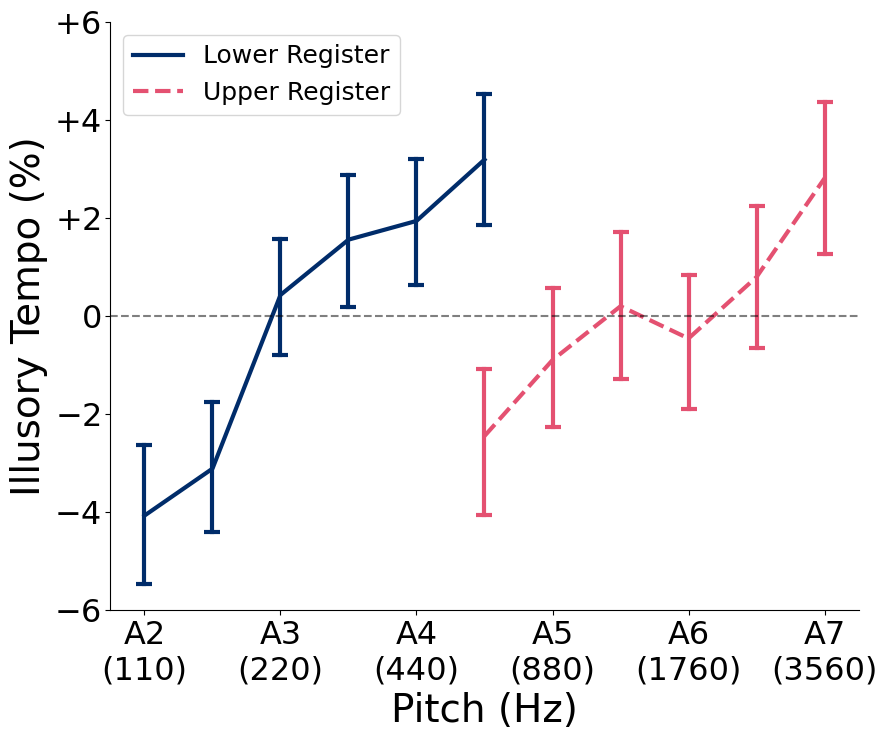

In [5]:
plt.figure()

# Plot data
sns.lineplot(x=adjusted_scores[adjusted_scores.range==0].pitch, y='illusory_tempo', 
             data=adjusted_scores[adjusted_scores.range==0], color='#002c6a', ls='-',
             marker='', err_style='bars', err_kws=dict(capsize=6, lw=3, capthick=3), lw=3, label='Lower Register')
sns.lineplot(x=adjusted_scores[adjusted_scores.range==1].pitch+5, y='illusory_tempo', 
             data=adjusted_scores[adjusted_scores.range==1], color='#e45171', ls='--',
             marker='', err_style='bars', err_kws=dict(capsize=6, lw=3, capthick=3), lw=3, label='Upper Register')
plt.axhline(0, ls='--', c='k', alpha=.5)

# Formatting
plt.legend(loc=2)
plt.xlabel('Pitch (Hz)')
plt.xticks(range(0, 11, 2), ['A2\n(110)', 'A3\n(220)', 'A4\n(440)', 'A5\n(880)', 'A6\n(1760)', 'A7\n(3560)'])
plt.ylabel('Illusory Tempo (%)')
plt.ylim(-6, 6)
plt.yticks(np.arange(-6, 7, 2), ['$-6$', '$-4$', '$-2$', '$0$', '$+2$', '$+4$', '$+6$'])
plt.gcf().set_size_inches(9, 7.5)
plt.tight_layout()

# Save figure
plt.gcf().savefig(FIGURE_PATH + 'illusory_tempo5.svg')

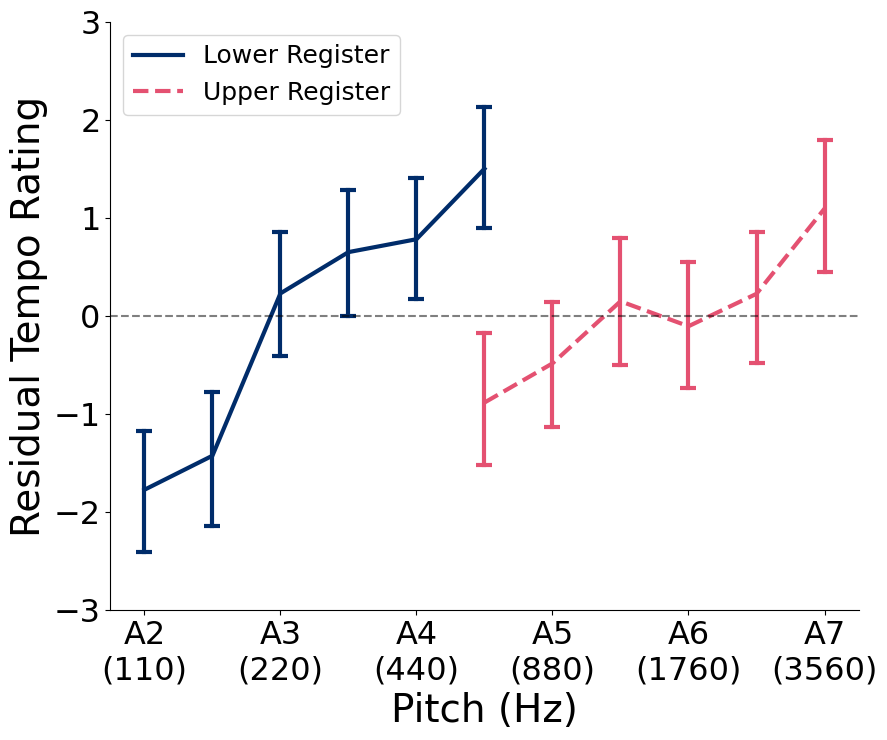

In [6]:
plt.figure()

# Plot data
sns.lineplot(x=adjusted_scores[adjusted_scores.range==0].pitch, y='residual', 
             data=adjusted_scores[adjusted_scores.range==0], color='#002c6a', ls='-',
             marker='', err_style='bars', err_kws=dict(capsize=6, lw=3, capthick=3), lw=3, label='Lower Register')
sns.lineplot(x=adjusted_scores[adjusted_scores.range==1].pitch+5, y='residual', 
             data=adjusted_scores[adjusted_scores.range==1], color='#e45171', ls='--',
             marker='', err_style='bars', err_kws=dict(capsize=6, lw=3, capthick=3), lw=3, label='Upper Register')
plt.axhline(0, ls='--', c='k', alpha=.5)

# Formatting
plt.legend(loc=2)
plt.xlabel('Pitch (Hz)')
plt.xticks(range(0, 11, 2), ['A2\n(110)', 'A3\n(220)', 'A4\n(440)', 'A5\n(880)', 'A6\n(1760)', 'A7\n(3560)'])
plt.ylabel('Residual Tempo Rating')
plt.ylim(-3, 3)
plt.gcf().set_size_inches(9, 7.5)
plt.tight_layout()

# Save figure
plt.gcf().savefig(FIGURE_PATH + 'pitch5.svg')

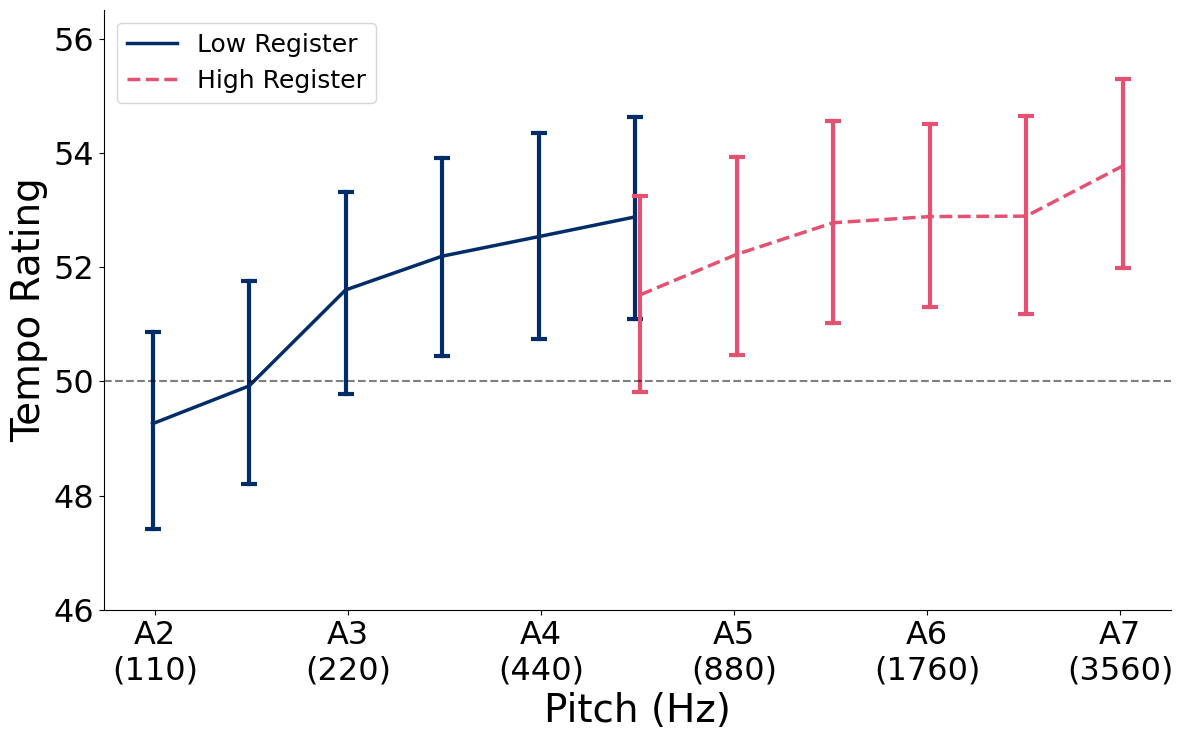

In [7]:
plt.figure()

# Plot data
sns.lineplot(x=adjusted_scores[adjusted_scores.range==0].pitch-.025, y='response', 
             data=adjusted_scores[adjusted_scores.range==0], color='#002c6a', 
             marker='', err_style='bars', err_kws=dict(capsize=6, lw=3, capthick=3), lw=2.5, label='Low Register')
sns.lineplot(x=adjusted_scores[adjusted_scores.range==1].pitch+5.025, y='response', 
                data=adjusted_scores[adjusted_scores.range==1], color='#e45171', ls='--',
                marker='', err_style='bars', err_kws=dict(capsize=6, lw=3, capthick=3), lw=2.5, label='High Register')
plt.axhline(50, ls='--', c='k', alpha=.5)

# Formatting
plt.legend(loc=2)
plt.xlabel('Pitch (Hz)')
plt.xticks(range(0, 11, 2), ['A2\n(110)', 'A3\n(220)', 'A4\n(440)', 'A5\n(880)', 'A6\n(1760)', 'A7\n(3560)'])
plt.ylabel('Tempo Rating')
plt.ylim(46, 56.5)
plt.gcf().set_size_inches(12, 7.5)
plt.tight_layout()

# Save figure
plt.gcf().savefig(FIGURE_PATH + 'raw_pitch5.svg')

# Survey Analysis

Please note that in order to preserve participant privacy, survey responses have not been made open access. Please contact the authors for access to data regarding demographics and musical experience.

In [8]:
# Load survey data and rename ID to subject
surv = pd.read_csv(SURVEYFILE)
surv.rename(columns={'id':'subject'}, inplace=True)

# Get list of subjects included in analyses
subj_list = data.subject.unique()

# Select only survey responses from participants included in analyses
surv = surv[np.in1d(surv.subject, subj_list)]
surv.reset_index()

# Add column indicating whether the participant was in the low or high range condition
surv['range'] = np.array([data[data.subject == s].range.iloc[0] for s in surv.subject])

# Print age stats
print('Minimum Age:', surv.age.min())
print('Maximum Age:', surv.age.max())
print('Mean Age:', surv.age.mean())
print('StdDev Age:', surv.age.std())

# Print gender stats
print('Number of Males:', np.sum(surv.gender == 'Male'))
print('Number of Females:', np.sum(surv.gender == 'Female'))
print('Number not reported:', np.sum(surv.gender== 'Prefer not to answer'))
print('Number self-described:', np.sum(surv.gender == 'Other'))
print('Self-descriptions:', [g for g in surv['gender[other]'] if type(g) == str])
print('Number of Low Females:', np.sum((surv.gender == 'Female') & (surv.range == 0)))
print('Number of Low Males:', np.sum((surv.gender == 'Male') & (surv.range == 0)))
print('Number of High Females:', np.sum((surv.gender == 'Female') & (surv.range == 1)))
print('Number of High Males:', np.sum((surv.gender == 'Male') & (surv.range == 1)))

Minimum Age: 17.0
Maximum Age: 41.0
Mean Age: 19.144736842105264
StdDev Age: 3.014206130391751
Number of Males: 11
Number of Females: 64
Number not reported: 0
Number self-described: 1
Self-descriptions: ['Non-binary assigned female at birth']
Number of Low Females: 33
Number of Low Males: 4
Number of High Females: 31
Number of High Males: 7
